# BM25

In [ ]:
import pandas as pd
import math
import numpy as np
from hugchat import hugchat
from hugchat.login import Login
import os
import openai
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import json




In [ ]:
openai.api_key = os.getenv("OPENAI_API_KEY")


In [23]:
# Classe BM25Okapi para ranqueamento de relevância
class BM25Okapi:
    def __init__(self, corpus, k1=1.5, b=0.75, epsilon=0.25):
        self.k1 = k1
        self.b = b
        self.epsilon = epsilon
        self.corpus = corpus
        self.corpus_size = len(corpus)
        self.doc_len = [len(doc) for doc in corpus]
        self.avgdl = sum(self.doc_len) / self.corpus_size
        self.doc_freqs = []
        self.idf = {}
        self._initialize()

    def _initialize(self):
        nd = {}
        for document in self.corpus:
            frequencies = {}
            for word in document:
                frequencies[word] = frequencies.get(word, 0) + 1
            self.doc_freqs.append(frequencies)
            for word in frequencies:
                nd[word] = nd.get(word, 0) + 1
        self._calc_idf(nd)

    def _calc_idf(self, nd):
        idf_sum = 0
        negative_idfs = []
        for word, freq in nd.items():
            idf = math.log(self.corpus_size - freq + 0.5) - math.log(freq + 0.5)
            self.idf[word] = idf
            idf_sum += idf
            if idf < 0:
                negative_idfs.append(word)
        self.average_idf = idf_sum / len(self.idf)
        eps = self.epsilon * self.average_idf
        for word in negative_idfs:
            self.idf[word] = eps

    def get_scores(self, query):
        scores = np.zeros(self.corpus_size)
        for q in query:
            q_idf = self.idf.get(q, 0)
            for idx, doc in enumerate(self.doc_freqs):
                f = doc.get(q, 0)
                denom = f + self.k1 * (1 - self.b + self.b * self.doc_len[idx] / self.avgdl)
                scores[idx] += q_idf * (f * (self.k1 + 1) / denom)
        return scores

# Função para carregar o corpus de um arquivo JSON
def load_corpus_from_json(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception as e:
        raise ValueError(f"Erro ao carregar o arquivo JSON: {e}")

    # Verificar se o JSON contém os campos necessários
    if not isinstance(data, list):
        raise ValueError("O arquivo JSON deve conter uma lista de objetos.")

    corpus = []
    for item in data:
        if "text" in item and item["text"]:
            corpus.append(item["text"])
        else:
            print(f"Entrada inválida ignorada: {item}")
    return corpus

# Caminho do arquivo JSON
file_path = r"D:\Users\Carlo\Faculdade\Processamento de Linguagem Natural\RAG\RAG-benchmark\data\fundamentos-all.json"

# Carregar e processar o corpus
raw_corpus = load_corpus_from_json(file_path)
tokenized_corpus = [doc.split() for doc in raw_corpus]  # Tokenização simples

# Inicializar o BM25 com o corpus
data_base = BM25Okapi(tokenized_corpus)


In [ ]:
# Função para recuperar o contexto usando BM25
def retrieve_base(query, db):
    # Tokenizar a consulta
    tokenized_query = query.split()

    # Obter scores de relevância dos documentos
    scores = db.get_scores(tokenized_query)

    # Selecionar os documentos mais relevantes (top 3 neste exemplo)
    top_n_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:3]
    top_documents = [db.corpus[i] for i in top_n_indices]

    # Validar e criar o texto do contexto
    context = "\n\n---\n\n".join([" ".join(doc) for doc in top_documents])
    return top_documents, context

# Função para gerar uma resposta usando o LLM e o contexto recuperado
def answer_query_base(query, db):
    _, context = retrieve_base(query, db)
    PROMPT_TEMPLATE = """
    Você é um assistente jurídico que responde à seguinte pergunta:
    <pergunta>
    {question}
    </pergunta>
    Você tem acesso aos seguintes documentos, que devem fornecer contexto à medida que responde à consulta:
    <contexto>
    {context}
    </contexto>
    Por favor, permaneça fiel ao contexto subjacente e só se desvie dele se tiver 100% de certeza de que já sabe a resposta.
    Responda à pergunta agora e evite fornecer preâmbulos como 'Aqui está a resposta', etc.
    """

    # Formatar o prompt com a pergunta e o contexto
    prompt = PROMPT_TEMPLATE.format(context=context, question=query)

    # Fazer a inferência com HuggingChat
    response = call_huggingchat(prompt, model_name="meta-llama/Meta-Llama-3.1-70B-Instruct")
    return response

# Exemplo de uso
start = time.time()
query = "posse provisória"
results, context = retrieve_base(query, data_base)
end = time.time()

print("Contexto Recuperado:")
print(context)

print("\nTempo de execução:")
print(end - start)

# Gerar o texto usando o LLM
response = answer_query_base(query, data_base)

print("\nTexto Gerado pelo LLM:")
print(response)


Contexto Recuperado:
Art. 678. A decisão que reconhecer suficientemente provado o domínio ou a posse determinará a suspensão das medidas constritivas sobre os bens litigiosos objeto dos embargos, bem como a manutenção ou a reintegração provisória da posse, se o embargante a houver requerido. Parágrafo único. O juiz poderá condicionar a ordem de manutenção ou de reintegração provisória de posse à prestação de caução pelo requerente, ressalvada a impossibilidade da parte economicamente hipossuficiente.

---

Art. 678. A decisão que reconhecer suficientemente provado o domínio ou a posse determinará a suspensão das medidas constritivas sobre os bens litigiosos objeto dos embargos, bem como a manutenção ou a reintegração provisória da posse, se o embargante a houver requerido. Parágrafo único. O juiz poderá condicionar a ordem de manutenção ou de reintegração provisória de posse à prestação de caução pelo requerente, ressalvada a impossibilidade da parte economicamente hipossuficiente.

--

In [ ]:
# Função para avaliar a saída do RAG com o GPT
def evaluate_rag_output(context, chunk_heading, text, model="gpt-3.5-turbo"):
    """
    Avalia se a saída do RAG está alinhada com o termo de busca e o texto de referência.

    Args:
        context (str): O contexto recuperado pelo RAG.
        chunk_heading (str): O termo de busca.
        text (str): O texto de referência correto do chunk.
        model (str): O modelo GPT a ser usado (padrão: gpt-3.5-turbo).

    Returns:
        str: Resposta do GPT com o julgamento.
    """
    prompt = f"""
    Você é um modelo treinado para avaliar respostas de sistemas baseados em Recuperação-Aumentada por Geração (RAG).
    Sua tarefa é julgar se o "contexto" recuperado pelo RAG está alinhado com o "termo de busca" (chunk_heading) e com o "texto de referência correto" (text).

    Aqui estão as informações fornecidas:
    - Contexto recuperado no RAG (3 contextos):
    {context}

    - Termo de busca:
    {chunk_heading}

    - Texto de referência correto:
    {text}

    Julgue se ao menos 1 dos 3 contextos é igual ao texto de referência, isso significará que o contexto está adequado ao termo de busca.
    Responda com "adequado" ou "inadequado".
    Não adicione nenhum comentário extra.
    # Formato da saída:
    Ex.:'adequado'
    Ex.:'inadequado'
    """
    try:
        response = openai.ChatCompletion.create(
            model=model,
            messages=[{"role": "user", "content": prompt}]
        )
        return response["choices"][0]["message"]["content"].strip()
    except Exception as e:
        return f"Erro ao avaliar: {str(e)}"


# Função para avaliar o JSON de teste
def evaluate_test_data(test_data, db):
    """
    Itera sobre um JSON de teste e avalia cada entrada usando o GPT como julgador.

    Args:
        test_data (list): Lista de entradas do JSON de teste.
        db (VectorDB): Instância do banco de vetores carregado.

    Returns:
        list: Resultados das avaliações.
    """
    results = []
    for item in tqdm(test_data, desc="LLM as a judge: ", unit="entrada"):
        chunk_heading = item["chunk_heading"]
        text = item["text"]
        _, context = retrieve_base(chunk_heading, db)

        evaluation = evaluate_rag_output(context, chunk_heading, text)
        results.append({
            "chunk_heading": chunk_heading,
            "context": context,
            "text": text,
            "evaluation": evaluation
        })

    return results


# Caminhos para os dados e resultados
test_data_path = r'D:\Users\Carlo\Faculdade\Processamento de Linguagem Natural\RAG\RAG-benchmark\data\fundamentos-test.json'
results_output_path = r'D:\Users\Carlo\Faculdade\Processamento de Linguagem Natural\RAG\RAG-benchmark\results\BM25.json'

# Carregar dados de teste
with open(test_data_path, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# Avaliar dados de teste
evaluation_results = evaluate_test_data(test_data, data_base)

# Salvar os resultados para análise posterior
with open(results_output_path, 'w', encoding='utf-8') as f:
    json.dump(evaluation_results, f, ensure_ascii=False, indent=4)

print("Avaliação concluída. Resultados salvos em:", results_output_path)


LLM as a judge: 100%|██████████| 100/100 [00:58<00:00,  1.72entrada/s]

Avaliação concluída. Resultados salvos em: D:\Users\Carlo\Faculdade\Processamento de Linguagem Natural\RAG\RAG-benchmark\results\BM25.json


Porcentagem de avaliações adequadas: 43.00%


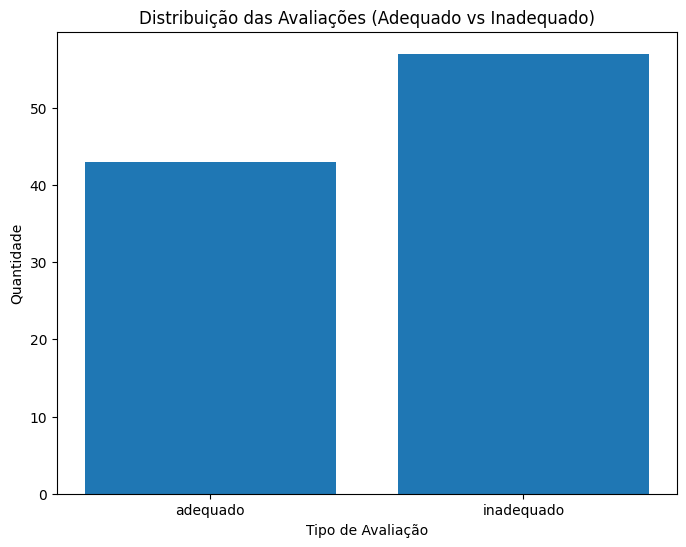

In [ ]:
# Carregar os resultados de avaliação
with open(r'D:\Users\Carlo\Faculdade\Processamento de Linguagem Natural\RAG\RAG-benchmark\results\BM25.json', 'r') as f:
    evaluation_results = json.load(f)

# Contar as avaliações adequadas e inadequadas
evaluation_counts = {"adequado": 0, "inadequado": 0}
for result in evaluation_results:
    evaluation = result["evaluation"].lower()  # Garantir consistência de casos
    if evaluation in evaluation_counts:
        evaluation_counts[evaluation] += 1

# Calcular a porcentagem de adequados
total = sum(evaluation_counts.values())
percentage_adequados = (evaluation_counts["adequado"] / total) * 100 if total > 0 else 0

# Criar o gráfico
labels = list(evaluation_counts.keys())
sizes = list(evaluation_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(labels, sizes)
plt.title("Distribuição das Avaliações (Adequado vs Inadequado)")
plt.xlabel("Tipo de Avaliação")
plt.ylabel("Quantidade")
plt.xticks(labels)

# Mostrar a porcentagem de adequados no console
print(f"Porcentagem de avaliações adequadas: {percentage_adequados:.2f}%")

plt.show()